# ESIDA DB Data Access Demo for Data Quality

In [3]:
import requests
from requests.auth import HTTPBasicAuth
from urllib.parse import urlencode
import datetime as dt

import pandas as pd
import geopandas

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

In [72]:
# Run for local database
HOST = 'http://localhost'
auth = None

In [4]:
# Run for hosted database
HOST = 'https://esida.informatik.haw-hamburg.de'
auth = HTTPBasicAuth('esida', 'opendata22')

# Get region shapes from database

In [5]:
# Parameters:
# - type=region|district (optional)
# - wkt (optional, returns Geometry)
q = {
    'type': 'region',
    'wkt': True
}
d = requests.get(f"{HOST}/api/v1/shapes?{urlencode(q)}", auth=auth).json()

# DataFrame
regions_gdf = geopandas.GeoDataFrame(d['data'])
if q['wkt']:
    regions_gdf['geometry'] = geopandas.GeoSeries.from_wkt(regions_gdf['wkt'])
    regions_gdf = regions_gdf.drop(columns=['wkt'])

In [6]:
regions = dict(zip(regions_gdf.id, regions_gdf.name))
regions_Name2Id = dict(zip(regions_gdf.name, regions_gdf.id))

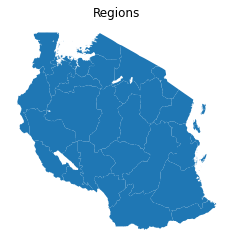

In [7]:
regions_gdf.plot()
plt.title('Regions')
plt.axis('off')
plt.show()

In [8]:
len(regions_gdf)

31

# Get district shapes from database

In [9]:
# Parameters:
# - type=region|district (optional)
# - wkt (optional, returns Geometry)
q = {
    'type': 'district',
    'wkt': True
}
d = requests.get(f"{HOST}/api/v1/shapes?{urlencode(q)}", auth=auth).json()

# DataFrame
districts_gdf = geopandas.GeoDataFrame(d['data'])
if q['wkt']:
    districts_gdf['geometry'] = geopandas.GeoSeries.from_wkt(districts_gdf['wkt'])
    districts_gdf = districts_gdf.drop(columns=['wkt'])

In [11]:
districts = dict(zip(districts_gdf.id, districts_gdf.name))

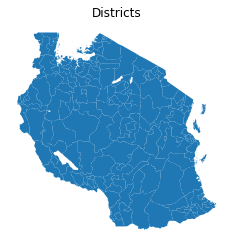

In [10]:
districts_gdf.plot()
plt.title('Districts')
plt.axis('off')
plt.show()

In [12]:
len(districts_gdf)

195

# Get data layer information

In [13]:
q = {}
d = requests.get(f"{HOST}/api/v1/parameters?{urlencode(q)}", auth=auth).json()

# DataFrame
datalayers_df = pd.DataFrame(d['data'])

In [14]:
datalayers_df

,loaded,parameter_id,raw_data_size,spatial_coverage,temporal_actual,temporal_coverage,temporal_expected,temporal_first,temporal_last,timelines
0,True,chirps_tprecit,15189291028,None,247696.0,0.272840,4017,2018-01-01,2022-04-29,date
1,True,chirts_maxt,528797948,None,577882.0,0.636545,4017,2010-01-01,2016-12-31,date
2,True,chirts_mint,528822524,None,577882.0,0.636545,4017,2010-01-01,2016-12-31,date
3,False,cia_worldfactbook,0,None,NaN,NaN,11,None,None,year
4,True,copernicus_built,4596882334,None,1130.0,0.454545,11,2015,2019,year
...,...,...,...,...,...,...,...,...,...,...
60,True,worldpop_age_70_80,320990328553,None,2486.0,1.000000,11,2000,2020,year
61,True,worldpop_popc,4685197313,None,2486.0,1.000000,11,2010,2020,year
62,True,worldpop_popd,51359509,None,2486.0,1.000000,11,2010,2020,year
63,True,worldpop_poverty,40878420,None,226.0,0.090909,11,2010,2010,year


In [21]:
# list all available loaded parameters
loaded_parameters = list(datalayers_df['parameter_id'].values)

# Get map of temporal coverage

In [25]:
# for wath parameters do want to show temporal coverage?
parameters = ['chirts_maxt', 'meteo_maxt']

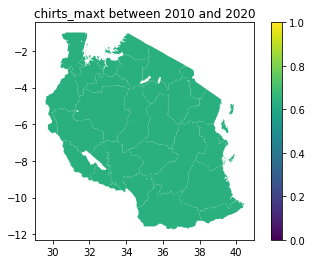

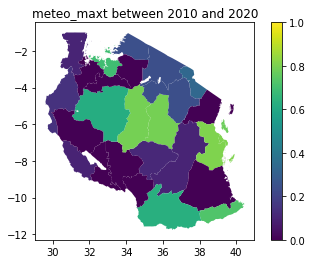

In [26]:
cache = {}
for parameter_id in parameters:
    rows = []

    for name, shape_id in regions_Name2Id.items():
        if shape_id not in cache:
            q = {
                'shape_id': shape_id,
            }
            d = requests.get(f"{HOST}/api/v1/parameters?{urlencode(q)}", auth=auth).json()

            cache[shape_id] = pd.DataFrame(d['data'])
        dfx = cache[shape_id]
        row = {
            'id': shape_id,
            'value': dfx[dfx['parameter_id'] == parameter_id].reset_index(drop=True).at[0, 'temporal_coverage']
        }
        rows.append(row)

    dfxv = pd.DataFrame(rows)
    gdfxv = regions_gdf.merge(dfxv, on='id')

    gdfxv.plot(column='value',  vmin=0, vmax=1, legend=True)
    plt.title(f"{parameter_id} between 2010 and 2020")
    plt.show()

# Spatial coverage

**ATTENTION**: takes very long!

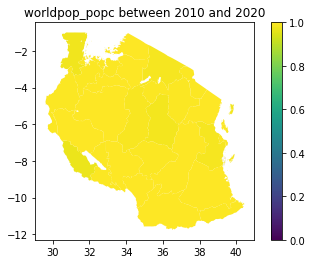

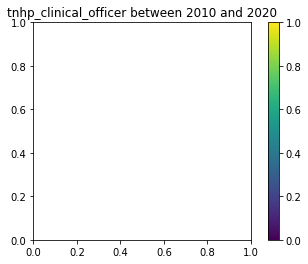

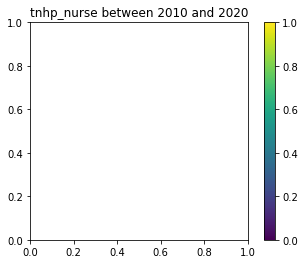

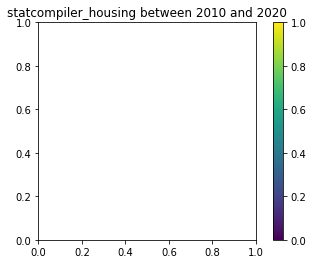

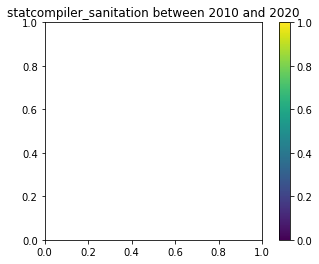

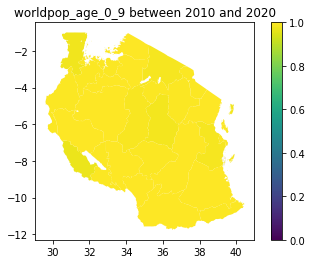

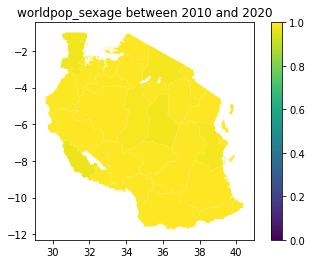

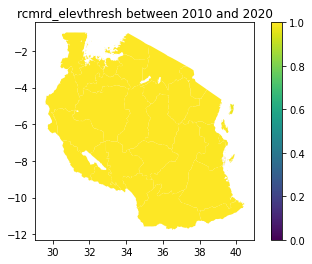

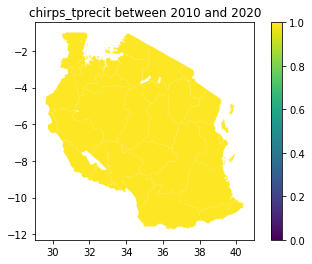

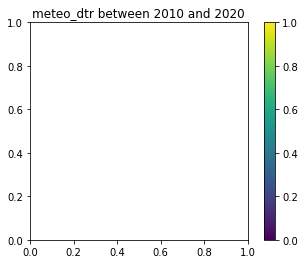

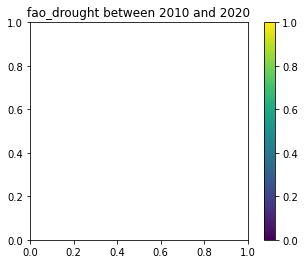

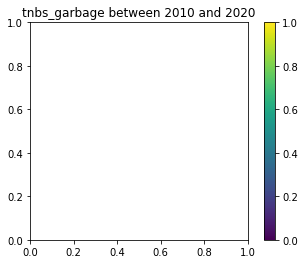

In [30]:
cache = {}
for parameter_id in loaded_parameters:
    rows = []

    for name, shape_id in regions_Name2Id.items():
        if shape_id not in cache:
            q = {
                'shape_id': shape_id,
                'da_spatial': True
            }
            d = requests.get(f"{HOST}/api/v1/parameters?{urlencode(q)}", auth=auth).json()

            cache[shape_id] = pd.DataFrame(d['data'])
        dfx = cache[shape_id]
        row = {
            'id': shape_id,
            'value': dfx[dfx['parameter_id'] == parameter_id].reset_index(drop=True).at[0, 'spatial_coverage']
        }
        rows.append(row)

    dfxv = pd.DataFrame(rows)
    gdfxv = regions_gdf.merge(dfxv, on='id')

    gdfxv.plot(column='value',  vmin=0, vmax=1, legend=True)
    plt.title(f"{parameter_id} between 2010 and 2020")
    plt.show()

# Spatial coverage for a single parameter

In [50]:
p = 'worldpop_popd'
q = {}
d = requests.get(f"{HOST}/api/v1/da_spatial/{p}?{urlencode(q)}", auth=auth).json()

df = pd.DataFrame(d['data'])

In [57]:
# Total spatial completness over all files (mean)
d['data_quality']

{'spatial_coverage': 0.9951079938821222}

In [83]:
# per file / per shape coverage
df.head(5)

,coverage,file,nodata_cells,parameter_id,shape_id,valid_cells
0,0.986538,tza_pd_2001_1km_UNadj.tiff,663.0,worldpop_popd,1,48586
1,0.994528,tza_pd_2001_1km_UNadj.tiff,237.0,worldpop_popd,2,43071
2,0.996700,tza_pd_2001_1km_UNadj.tiff,51.0,worldpop_popd,3,15405
3,1.000000,tza_pd_2001_1km_UNadj.tiff,0.0,worldpop_popd,4,32728
4,1.000000,tza_pd_2001_1km_UNadj.tiff,0.0,worldpop_popd,5,82835


In [81]:
df.to_csv('da_spatial_worldpop_popd.csv', index=False)

In [84]:
spatial_coverage = []
for shape_id, name in regions.items():
    dfx = df[df['shape_id'] == shape_id]
    spatial_coverage.append({
        'id': shape_id,
        'coverage': dfx['coverage'].mean()
    })

In [85]:
spatial_coverage_df = pd.DataFrame(spatial_coverage)

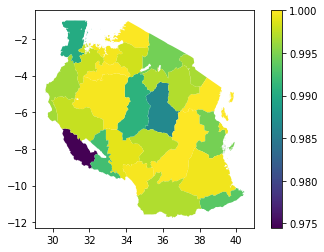

In [104]:

#fig, ax = plt.subplots(1, 1, figsize=(10,10)) # rows, cols

ax = regions_gdf.merge(spatial_coverage_df, on='id').plot(column='coverage', legend=True, legend_kwds={"fmt": "{:.0f}aa"})
#ax.yaxis.set_major_formatter(mtick.PercentFormatter())



In [76]:
spatial_coverage = []
for shape_id, name in districts.items():
    dfx = df[df['shape_id'] == shape_id]
    spatial_coverage.append({
        'id': shape_id,
        'coverage': dfx['coverage'].mean()
    })
spatial_coverage_df = pd.DataFrame(spatial_coverage)

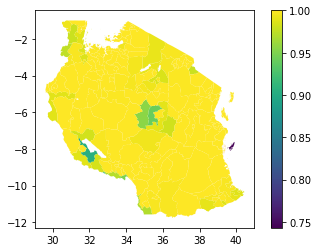

In [80]:
ax = districts_gdf.merge(spatial_coverage_df, on='id').plot(column='coverage', legend=True)
#districts_gdf.plot(ax=ax, facecolor='none', ec='black')